<a href="https://colab.research.google.com/github/Supriya090/Tacotron2SpeechSynthesis/blob/main/Tacotron2SpeechSynthesisNepali_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tacotron 2 Training and Synthesis Notebook**
originally based on the following notebooks
https://github.com/NVIDIA/tacotron2,
https://bit.ly/3F4DkH2
and those presented in Adam is cool and stuff (https://youtu.be/LQAOCXdU8p8 and https://youtu.be/XLt_K_692Mc)

**WaveGlow model weights pre-trained on the LJ Speech dataset** can be downloaded from: https://catalog.ngc.nvidia.com/orgs/nvidia/models/waveglow_ljs_256channels

#Data Preparation



In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#@title Download Tacotron 2
import os
!git clone -q https://github.com/NVIDIA/tacotron2
os.chdir('tacotron2')
!git submodule init
!git submodule update
!pip install -q unidecode tensorboardX

Submodule 'waveglow' (https://github.com/NVIDIA/waveglow) registered for path 'waveglow'
Cloning into '/content/tacotron2/waveglow'...
Submodule path 'waveglow': checked out '5bc2a53e20b3b533362f974cfa1ea0267ae1c2b1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 13.5 MB/s eta 0:00:00


Upload Data

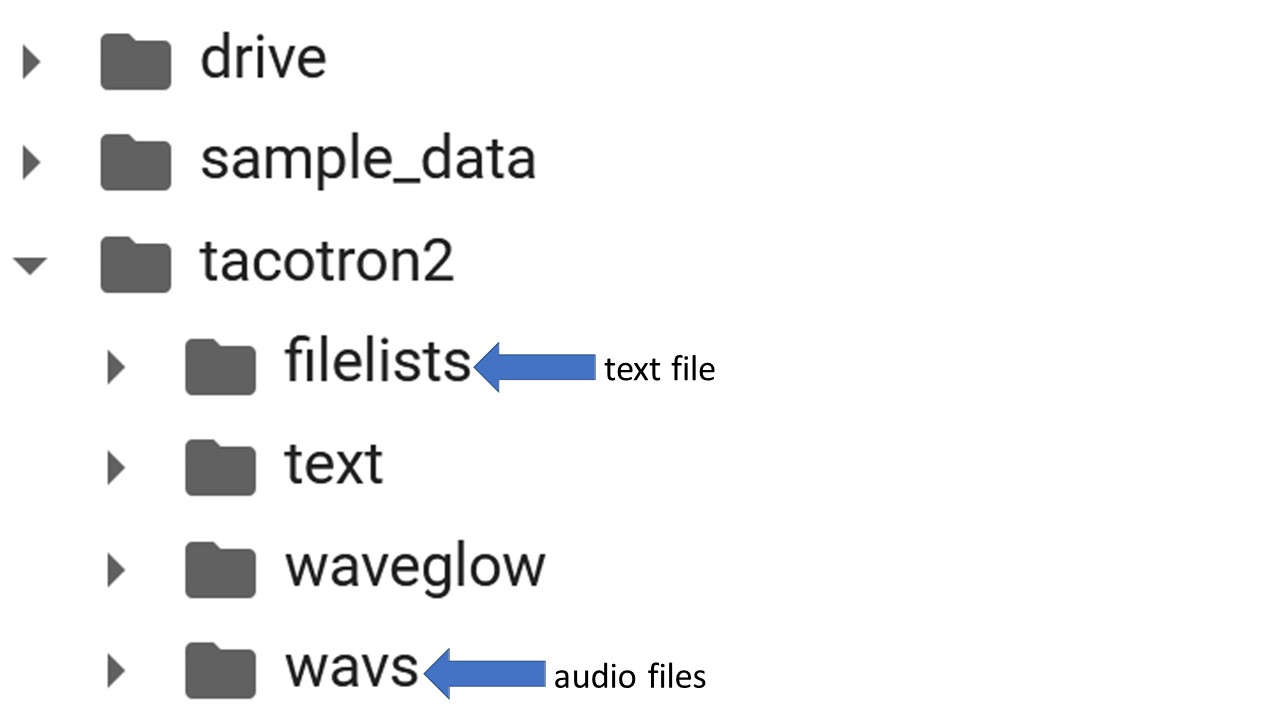

In [ ]:
# Creating Hyperparameters

from text import symbols

class HParams:
    def __init__(self) -> None:
        self.epochs=500
        self.iters_per_checkpoint=1000
        self.seed=1234
        self.dynamic_loss_scaling=True
        self.fp16_run=False
        self.distributed_run=False
        self.dist_backend="nccl"
        self.dist_url="tcp://localhost:54321"
        self.cudnn_enabled=True
        self.cudnn_benchmark=False
        self.ignore_layers=['embedding.weight']

        ################################
        # Data Parameters             #
        ################################
        self.load_mel_from_disk=False
        self.training_files='./filelists/train_list.txt'
        self.validation_files='./filelists/val_list.txt'
        self.text_cleaners=['transliteration_cleaners']

        ################################
        # Audio Parameters             #
        ################################
        self.max_wav_value=32768.0
        self.sampling_rate=22050
        self.filter_length=1024
        self.hop_length=256
        self.win_length=1024
        self.n_mel_channels=80
        self.mel_fmin=0.0
        self.mel_fmax=8000.0

        ################################
        # Model Parameters             #
        ################################
        self.n_symbols=len(symbols)
        self.symbols_embedding_dim=512

        # Encoder parameters
        self.encoder_kernel_size=5
        self.encoder_n_convolutions=3
        self.encoder_embedding_dim=512

        # Decoder parameters
        self.n_frames_per_step=1  # currently only 1 is supported
        self.decoder_rnn_dim=1024
        self.prenet_dim=256
        self.max_decoder_steps=10000
        self.gate_threshold=0.5
        self.p_attention_dropout=0.1
        self.p_decoder_dropout=0.1

        # Attention parameters
        self.attention_rnn_dim=1024
        self.attention_dim=128

        # Location Layer parameters
        self.attention_location_n_filters=32
        self.attention_location_kernel_size=31

        # Mel-post processing network parameters
        self.postnet_embedding_dim=512
        self.postnet_kernel_size=5
        self.postnet_n_convolutions=5

        ################################
        # Optimization Hyperparameters #
        ################################
        self.use_saved_learning_rate=False
        self.learning_rate=1e-3
        self.weight_decay=1e-6
        self.grad_clip_thresh=1.0
        self.batch_size=1
        self.mask_padding=True  # set model's padded outputs to padded values

hparams = HParams()

/content/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/content/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


#Model Preparation

In [ ]:
#@title Training Model

%matplotlib inline
import os
if os.getcwd() != '/content/tacotron2':
    os.chdir('tacotron2')
import time
import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
 
import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename, 
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('/content/drive/MyDrive/wavs_finetuning/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("interrupt received while saving loss, waiting for save to complete.")
        torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_epoch, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    wandb.log({"Validation Loss": val_loss})
    wandb.watch(model)
    
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_epoch)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
            print(iteration)
    else:
      os.path.isfile("tacotron2_statedict.pt")
      model = warm_start_model("tacotron2_statedict.pt", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists
    
    start_epoch = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINING LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_epoch = time.perf_counter()
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        wandb.log({"Training loss": reduced_loss})
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_epoch, learning_rate)
        save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)

def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:।"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
# ---- Replace .wav with .npy in filelists ----

warm_start=False
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
model_filename = 'Shruti_finetuned_male'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 1
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/MyDrive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/tacotron2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/MyDrive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

In [ ]:
#@title Model Name
model_filename = "Shruti_finetuned_male" #@param {type:"string"}

In [ ]:
#@title Lists
hparams.training_files = "filelists/train_list.txt"
hparams.validation_files = "filelists/val_list.txt"

In [ ]:
#@title Parameters

#These two are the most important
hparams.batch_size = 1 # Controls how fast the model trains. Don't set this too high, or else it will GPU will OOM (out of memory). 30-ish is usually a good number if you have a bigger dataset. If the number of audio files is more than/about the same as this number, it won't train properly, and you won't be able to use it.
hparams.epochs = 300 # Maxmimum epochs (number of times the AI looks through the dataset) to train

hparams.sampling_rate = 22050
#The rest aren't that important
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate
hparams.A_ = 5e-4                   # Start/Max Learning Rate
hparams.B_ = 8000                   # Decay RZZZZate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate
generate_mels = True # Don't change
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.load_mel_from_disk = True
hparams.ignore_layers = [] # Layers to reset (None by default, other than foreign languages this param can be ignored)

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/MyDrive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/tacotron2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/MyDrive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

In [ ]:
#@title MEL Spectrogram
if generate_mels:
    create_mels()

Generating Mels


  0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
#@title Check the Data Set
check_dataset(hparams)

Checking Training Files
Checking Validation Files
Finished Checking


#Training

In [ ]:
!pip install wandb

!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project="shruti-male", entity="quadruples")

wandb: Currently logged in as: supriya090 (quadruples). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.config = {
  "learning_rate": 0.00001,
  "epochs": 50,
  "batch_size": 2
}#a749e410cd3589b5c1c4adc48b2fe40c441d47ad - Ranju
  #f527c00843bb45d12f29d8c9241536d21de52cba - Supriya

In [ ]:
 print(checkpoint_path, warm_start)

/content/drive/MyDrive/colab/outdir/Shruti_finetuned_male False


In [ ]:
import os
print(os.path.exists(checkpoint_path))

True


FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
Loading checkpoint '/content/drive/MyDrive/colab/outdir/Shruti_finetuned_male'
Loaded checkpoint '/content/drive/MyDrive/colab/outdir/Shruti_finetuned_male' from iteration 18837
18838


  0%|          | 0/190 [00:00<?, ?it/s]


Starting Epoch: 110 Iteration: 18838


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 110 Validation loss 19008:  0.818707  Time: 5.3m LR: 0.000303


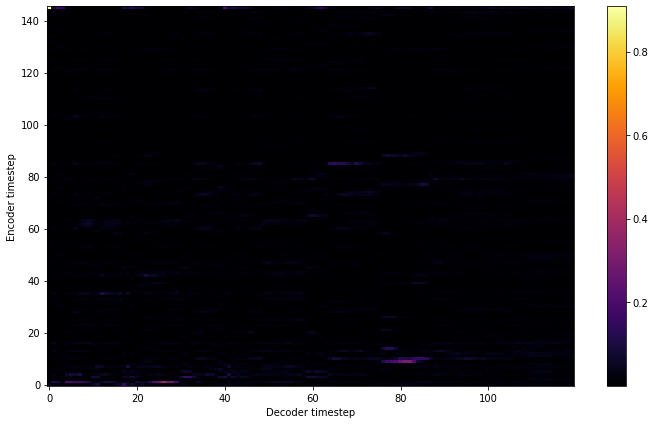

Saving model and optimizer state at iteration 19008 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 111 Iteration: 19008


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 111 Validation loss 19178:  0.723171  Time: 5.1m LR: 0.000297


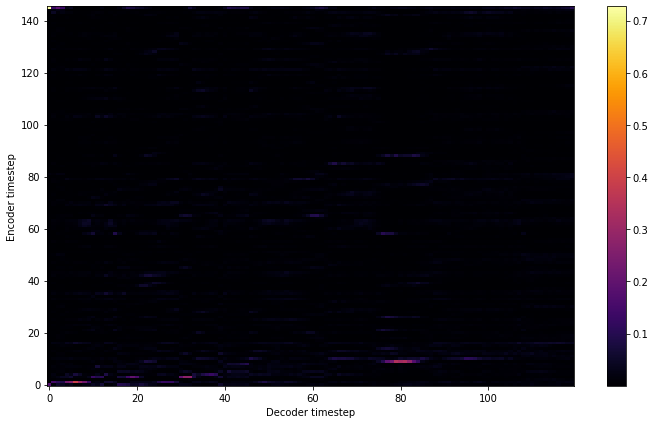

Saving model and optimizer state at iteration 19178 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 112 Iteration: 19178


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 112 Validation loss 19348:  0.706610  Time: 5.1m LR: 0.000290


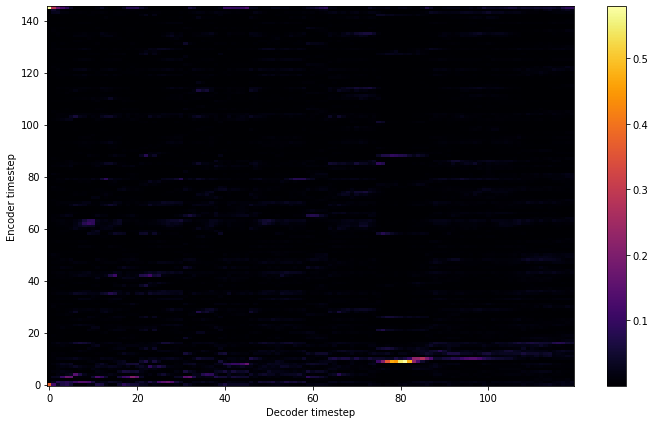

Saving model and optimizer state at iteration 19348 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 113 Iteration: 19348


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 113 Validation loss 19518:  0.679676  Time: 5.1m LR: 0.000284


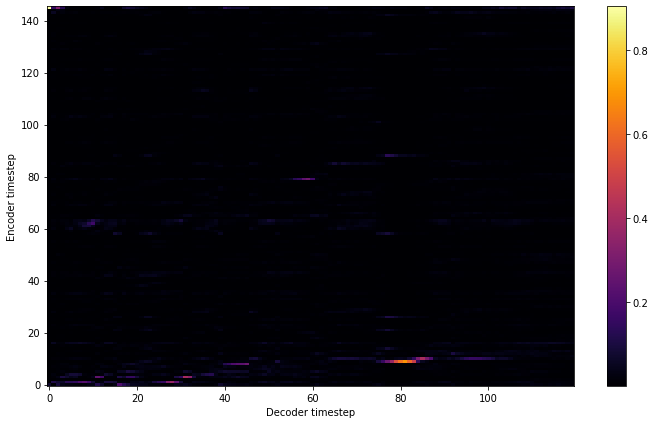

Saving model and optimizer state at iteration 19518 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 114 Iteration: 19518


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 114 Validation loss 19688:  0.681917  Time: 5.1m LR: 0.000278


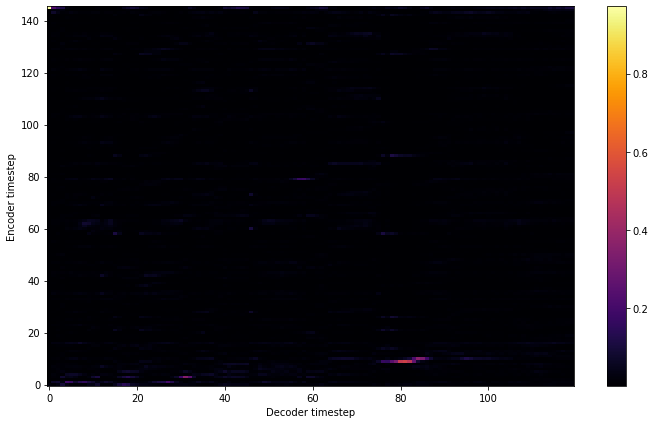

Saving model and optimizer state at iteration 19688 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 115 Iteration: 19688


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 115 Validation loss 19858:  0.679559  Time: 5.1m LR: 0.000272


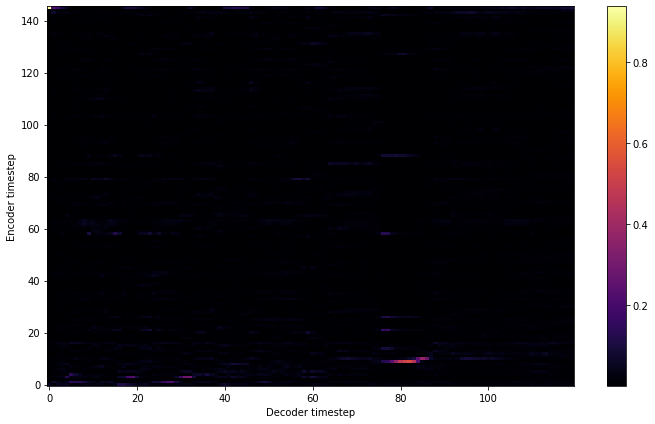

Saving model and optimizer state at iteration 19858 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 116 Iteration: 19858


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 116 Validation loss 20028:  0.673250  Time: 5.1m LR: 0.000267


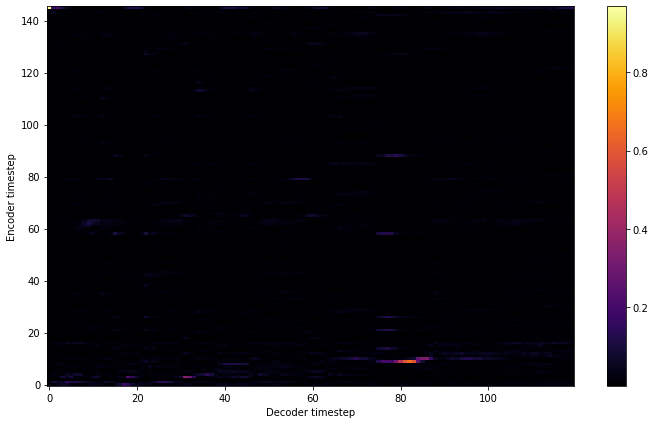

Saving model and optimizer state at iteration 20028 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 117 Iteration: 20028


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 117 Validation loss 20198:  0.665091  Time: 5.1m LR: 0.000261


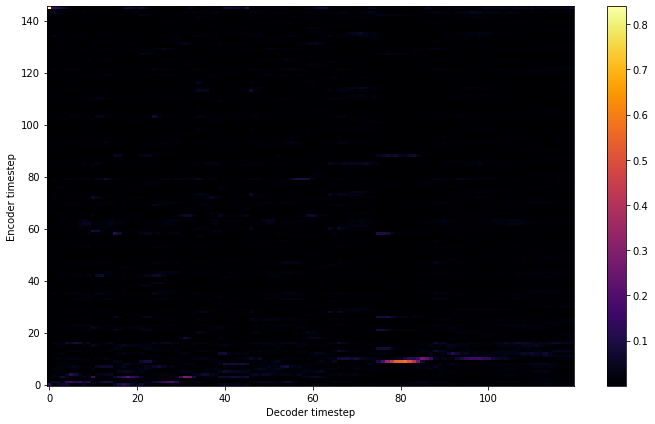

Saving model and optimizer state at iteration 20198 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 118 Iteration: 20198


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 118 Validation loss 20368:  0.662749  Time: 5.1m LR: 0.000256


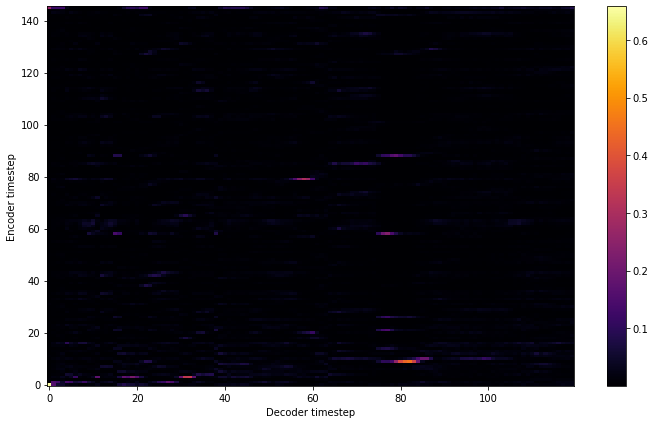

Saving model and optimizer state at iteration 20368 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 119 Iteration: 20368


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 119 Validation loss 20538:  0.651241  Time: 5.1m LR: 0.000250


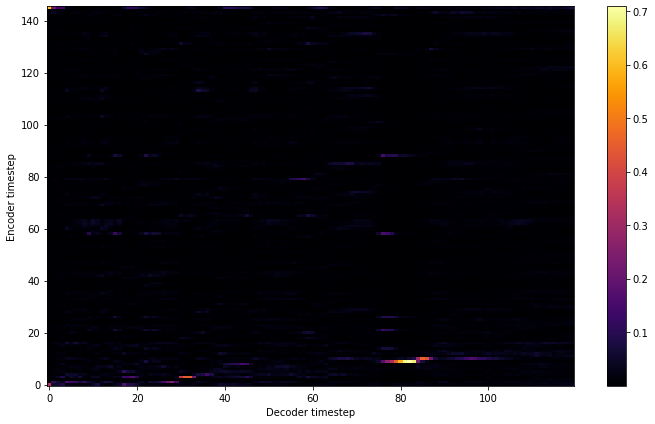

Saving model and optimizer state at iteration 20538 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 120 Iteration: 20538


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 120 Validation loss 20708:  0.676489  Time: 5.1m LR: 0.000245


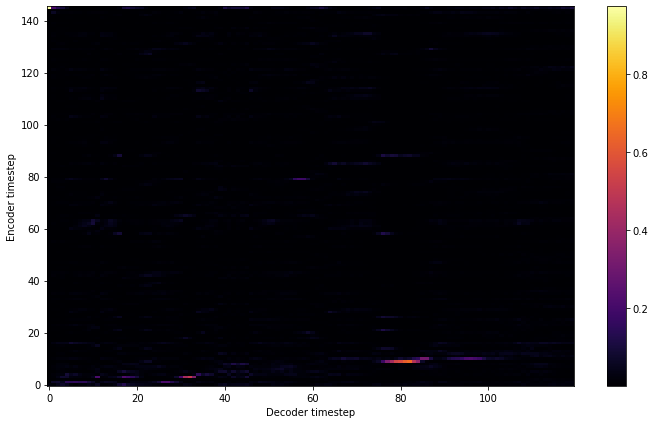

Saving model and optimizer state at iteration 20708 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 121 Iteration: 20708


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 121 Validation loss 20878:  0.671058  Time: 5.1m LR: 0.000240


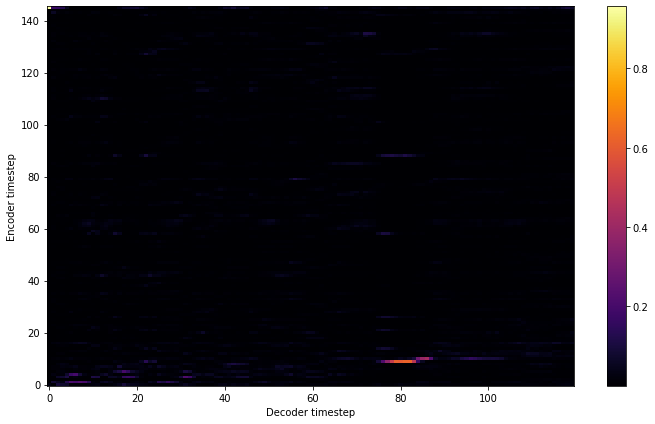

Saving model and optimizer state at iteration 20878 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 122 Iteration: 20878


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 122 Validation loss 21048:  0.665278  Time: 5.1m LR: 0.000235


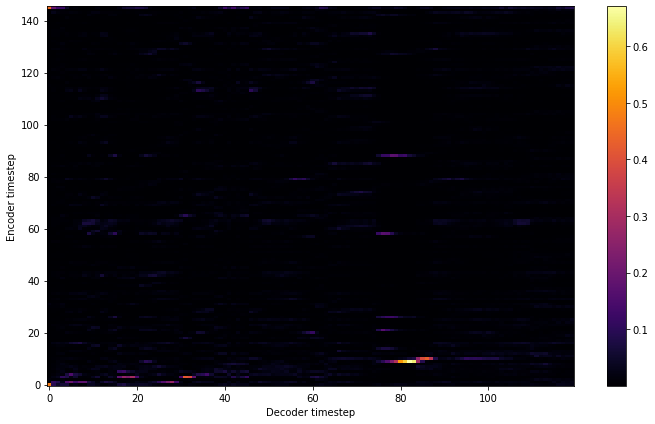

Saving model and optimizer state at iteration 21048 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 123 Iteration: 21048


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 123 Validation loss 21218:  0.679451  Time: 5.1m LR: 0.000230


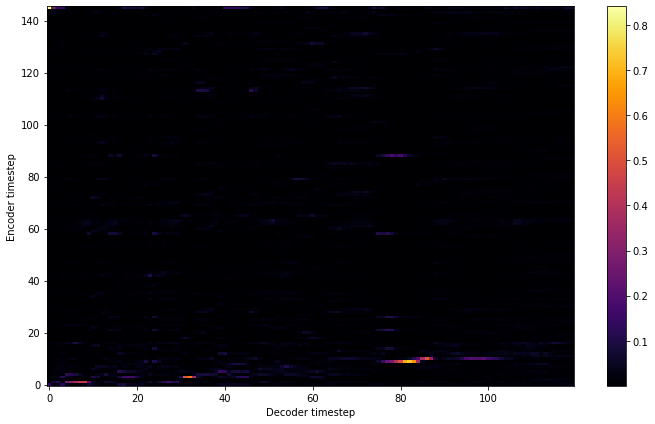

Saving model and optimizer state at iteration 21218 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 124 Iteration: 21218


  0%|          | 0/170 [00:00<?, ?it/s]

Epoch: 124 Validation loss 21388:  0.677352  Time: 5.1m LR: 0.000225


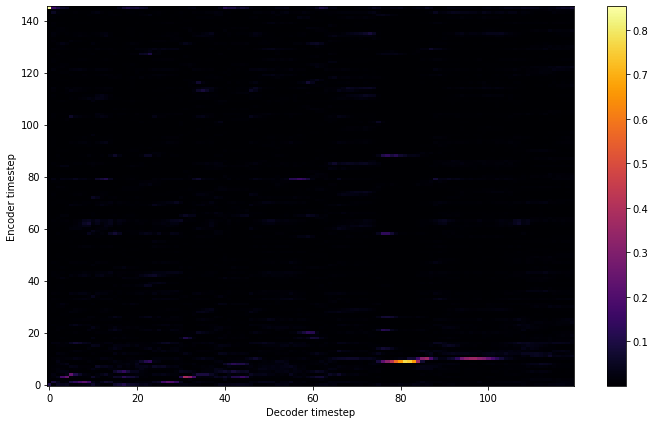

Saving model and optimizer state at iteration 21388 to /content/drive/MyDrive/colab/outdir/Shruti_finetuned_male
Model Saved

Starting Epoch: 125 Iteration: 21388


  0%|          | 0/170 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
#@title Training
print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path, 
        warm_start, n_gpus, rank, group_name, hparams, log_directory2)

#Speech Synthesis

##With HiFi-GAN##

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
#@markdown Config:

#@markdown Restart the code to apply any changes.

#Add new characters here.
#Universal HiFi-GAN (has some robotic noise): 1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW
Tacotron2_Model = '/content/drive/MyDrive/colab/outdir/Shruti_finetuned_male_prabin'#@param {type:"string"}
TACOTRON2_ID = Tacotron2_Model
HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

# Check if Initilized
try:
    initilized
except NameError:
    print("Setting up, please wait.\n")
    !pip install tqdm -q
    from tqdm.notebook import tqdm
    with tqdm(total=5, leave=False) as pbar:
        import os
        from os.path import exists, join, basename, splitext
        !pip install gdown
        git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
        project_name = splitext(basename(git_repo_url))[0]
        if not exists(project_name):
            # clone and install
            !git clone -q --recursive {git_repo_url}
            !git clone -q --recursive https://github.com/SortAnon/hifi-gan
            !pip install -q librosa unidecode
        pbar.update(1) # downloaded TT2 and HiFi-GAN
        import sys
        sys.path.append('hifi-gan')
        sys.path.append(project_name)
        import time
        import matplotlib
        import matplotlib.pylab as plt
        import gdown
        d = 'https://drive.google.com/uc?id='

        %matplotlib inline
        import IPython.display as ipd
        import numpy as np
        import torch
        import json
        from model import Tacotron2
        from layers import TacotronSTFT
        from audio_processing import griffin_lim
        from text import text_to_sequence
        from env import AttrDict
        from meldataset import MAX_WAV_VALUE
        from models import Generator

        pbar.update(1) # initialized Dependancies

        graph_width = 900
        graph_height = 360
        def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()

        # Setup Pronounciation Dictionary
        thisdict = {}
        for line in reversed((open('/content/drive/MyDrive/merged.dict.txt', "r").read()).splitlines()):
            thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

        pbar.update(1) # Downloaded and Set up Pronounciation Dictionary

        def ARPA(text, punctuation=r"!?,।.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

        def get_hifigan(MODEL_ID):
            # Download HiFi-GAN
            hifigan_pretrained_model = 'hifimodel'
            gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)
            if not exists(hifigan_pretrained_model):
                raise Exception("HiFI-GAN model failed to download!")

            # Load HiFi-GAN
            conf = os.path.join("hifi-gan", "config_v1.json")
            with open(conf) as f:
                json_config = json.loads(f.read())
            h = AttrDict(json_config)
            torch.manual_seed(h.seed)
            hifigan = Generator(h).to(torch.device(device))
            state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device(device))
            hifigan.load_state_dict(state_dict_g["generator"])
            hifigan.eval()
            hifigan.remove_weight_norm()
            return hifigan, h

        hifigan, h = get_hifigan(HIFIGAN_ID)
        pbar.update(1) # Downloaded and Set up HiFi-GAN

        def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

        def get_Tactron2(MODEL_ID):
            # Download Tacotron2
            tacotron2_pretrained_model = TACOTRON2_ID
            if not exists(tacotron2_pretrained_model):
                raise Exception("Tacotron2 model failed to download!")
            # Load Tacotron2 and Config
            hparams.sampling_rate = 22050
            hparams.max_decoder_steps = 10000 # Max Duration
            hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
            model = Tacotron2(hparams)
            model.to(torch.device(device))
            state_dict = torch.load(tacotron2_pretrained_model, map_location=torch.device(device))['state_dict']
            if has_MMI(state_dict):
                raise Exception("ERROR: This notebook does not currently support MMI models.")
            model.load_state_dict(state_dict)
            _ = model.eval()
            return model, hparams

        model, hparams = get_Tactron2(TACOTRON2_ID)
        previous_tt2_id = TACOTRON2_ID

        pbar.update(1) # Downloaded and Set up Tacotron2

    from IPython.display import clear_output
    clear_output()
    initilized = "Ready"

if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h = get_hifigan(HIFIGAN_ID)
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = False #@param {type:"boolean"}
# disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
show_graphs = True #@param {type:"boolean"}
max_duration = 25 #this does nothing
model.decoder.max_decoder_steps = 10000 #@param {type:"integer"}
stop_threshold = 0.324 #@param {type:"number"}
model.decoder.gate_threshold = stop_threshold

Updating Models


Downloading...
From: https://drive.google.com/uc?id=1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW
To: /content/tacotron2/hifimodel
100%|██████████| 55.8M/55.8M [00:00<00:00, 238MB/s]


Removing weight norm...


In [ ]:
def end_to_end_infer(text):
    for i in [x for x in text.split("\n") if len(x)]:
        if i[-1] != ";": i=i+";" 
        with torch.no_grad(): # save VRAM by not including gradients
            sequence = np.array(text_to_sequence(i, ['transliteration_cleaners']))[None, :]
            sequence = torch.autograd.Variable(torch.from_numpy(sequence)).to(device).long()
            mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
            y_g_hat = hifigan(mel_outputs_postnet.float()).to(device)
            audio = y_g_hat.squeeze()
            audio = audio * MAX_WAV_VALUE
            print("")
            ipd.display(ipd.Audio(audio.cpu().numpy().astype("int16"), rate=hparams.sampling_rate))

In [ ]:
print(f"Current Config:\npronounciation_dictionary: {pronounciation_dictionary}\nshow_graphs: {show_graphs}\nmax_duration (in seconds): {max_duration}\nstop_threshold: {stop_threshold}\n\n")

time.sleep(1)
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        if line == "":
            continue
        end_to_end_infer(line)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break

Current Config:
pronounciation_dictionary: False
show_graphs: True
max_duration (in seconds): 25
stop_threshold: 0.324


Enter/Paste your text.
--------------------------------------------------
एक समयको कुरा हो, एक किसानको खेत धेरै थियो तर खेत लाई चाहिने पानी थिएन।



--------------------------------------------------


##With Waveglow##

In [ ]:
#@title Install Tacotron and Waveglow
import os
from os.path import exists, join, basename, splitext
!pip install gdown
git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 2fd4e63
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
import gdown
d = 'https://drive.google.com/uc?id='

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Load Pretrained Models
force_download_TT2 = True
tacotron2_pretrained_model = '/content/drive/MyDrive/colab/outdir/Shruti_finetuned'#@param {type:"string"}
waveglow_pretrained_model = '/content/drive/MyDrive/colab/outdir/waveglow_256channels_ljs_v3.pt'#@param {type:"string"}

In [ ]:
#@markdown Config:

#@markdown Restart the code to apply any changes.

#Add new characters here.
#Universal HiFi-GAN (has some robotic noise): 1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW
Tacotron2_Model = '/content/drive/MyDrive/colab/outdir/Shruti_finetuned'#@param {type:"string"}
TACOTRON2_ID = Tacotron2_Model
HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

# Check if Initilized
try:
    initilized
except NameError:
    print("Setting up, please wait.\n")
    !pip install tqdm -q
    from tqdm.notebook import tqdm
    with tqdm(total=5, leave=False) as pbar:
        import os
        from os.path import exists, join, basename, splitext
        !pip install gdown
        git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
        project_name = splitext(basename(git_repo_url))[0]
        if not exists(project_name):
            # clone and install
            !git clone -q --recursive {git_repo_url}
            !git clone -q --recursive https://github.com/SortAnon/hifi-gan
            !pip install -q librosa unidecode
        pbar.update(1) # downloaded TT2 and HiFi-GAN
        import sys
        sys.path.append('hifi-gan')
        sys.path.append(project_name)
        import time
        import matplotlib
        import matplotlib.pylab as plt
        import gdown
        d = 'https://drive.google.com/uc?id='

        %matplotlib inline
        import IPython.display as ipd
        import numpy as np
        import torch
        import json
        from model import Tacotron2
        from layers import TacotronSTFT
        from audio_processing import griffin_lim
        from text import text_to_sequence
        from env import AttrDict
        from meldataset import MAX_WAV_VALUE
        from models import Generator

        pbar.update(1) # initialized Dependancies

        graph_width = 900
        graph_height = 360
        def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()

        # Setup Pronounciation Dictionary
        !gdown --id '1E12g_sREdcH5vuZb44EZYX8JjGWQ9rRp'
        thisdict = {}
        for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
            thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

        pbar.update(1) # Downloaded and Set up Pronounciation Dictionary

        def ARPA(text, punctuation=r"!?,।.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

        def get_hifigan(MODEL_ID):
            # Download HiFi-GAN
            hifigan_pretrained_model = 'hifimodel'
            gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)
            if not exists(hifigan_pretrained_model):
                raise Exception("HiFI-GAN model failed to download!")

            # Load HiFi-GAN
            conf = os.path.join("hifi-gan", "config_v1.json")
            with open(conf) as f:
                json_config = json.loads(f.read())
            h = AttrDict(json_config)
            torch.manual_seed(h.seed)
            hifigan = Generator(h).to(torch.device("cuda"))
            state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device(device))
            hifigan.load_state_dict(state_dict_g["generator"])
            hifigan.eval()
            hifigan.remove_weight_norm()
            return hifigan, h

        hifigan, h = get_hifigan(HIFIGAN_ID)
        pbar.update(1) # Downloaded and Set up HiFi-GAN

        def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

        def get_Tactron2(MODEL_ID):
            # Download Tacotron2
            tacotron2_pretrained_model = TACOTRON2_ID
            if not exists(tacotron2_pretrained_model):
                raise Exception("Tacotron2 model failed to download!")
            # Load Tacotron2 and Config
            hparams.sampling_rate = 22050
            hparams.max_decoder_steps = 3000 # Max Duration
            hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
            model = Tacotron2(hparams)
            model.to(torch.device("cuda"))
            state_dict = torch.load(tacotron2_pretrained_model, map_location=torch.device('cpu'))['state_dict']
            if has_MMI(state_dict):
                raise Exception("ERROR: This notebook does not currently support MMI models.")
            model.load_state_dict(state_dict)
            _ = model.eval()
            return model, hparams

        model, hparams = get_Tactron2(TACOTRON2_ID)
        previous_tt2_id = TACOTRON2_ID

        pbar.update(1) # Downloaded and Set up Tacotron2

        # Extra Info
        def end_to_end_infer(text):
            for i in [x for x in text.split("\n") if len(x)]:
                if i[-1] != ";": i=i+";" 
                with torch.no_grad(): # save VRAM by not including gradients
                    sequence = np.array(text_to_sequence(i, ['transliteration_cleaners']))[None, :]
                    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).to("cuda").long()
                    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence).to("cuda")
                    y_g_hat = hifigan(mel_outputs_postnet.float()).to("cuda")
                    audio = y_g_hat.squeeze()
                    audio = audio * MAX_WAV_VALUE
                    print("")
                    ipd.display(ipd.Audio(audio.cpu().numpy().astype("int16"), rate=hparams.sampling_rate))
    from IPython.display import clear_output
    clear_output()
    initilized = "Ready"

if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h = get_hifigan(HIFIGAN_ID)
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = False #@param {type:"boolean"}
# disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
show_graphs = True #@param {type:"boolean"}
max_duration = 25 #this does nothing
model.decoder.max_decoder_steps = 10000 #@param {type:"integer"}
stop_threshold = 0.324 #@param {type:"number"}
model.decoder.gate_threshold = stop_threshold

In [ ]:
#@title Parameters
# Load Tacotron2 (run this cell every time you change the model)
hparams.sampling_rate = 22050 # Don't change this
hparams.max_decoder_steps = 10000 # How long the audio will be before it cuts off (1000 is about 11 seconds)
hparams.gate_threshold = 0.1 # Model must be 90% sure the clip is over before ending generation (the higher this number is, the more likely that the AI will keep generating until it reaches the Max Decoder Steps)
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval().half()

# Load WaveGlow
waveglow = torch.load(waveglow_pretrained_model)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

NameError: ignored

यस चाडले मानिसले प्रकृति र जीवजन्तुमा एकता, सद्भावना र समानताको भावना राख्नुपर्छ भन्ने संदेश पनि दिन्छ।
यस चाडले मानिसले प्रकृति र जीवजन्तुमा एकता, सद्भावना र समानताको भावना राख्नुपर्छ भन्ने संदेश पनि दिन्छ।;


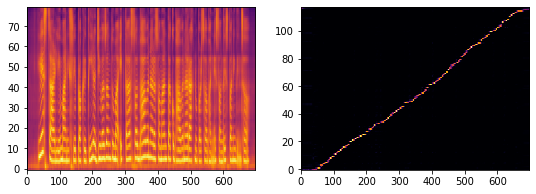

In [ ]:
#@title Let's Have Fun!
text = '\u092F\u0938 \u091A\u093E\u0921\u0932\u0947 \u092E\u093E\u0928\u093F\u0938\u0932\u0947 \u092A\u094D\u0930\u0915\u0943\u0924\u093F \u0930 \u091C\u0940\u0935\u091C\u0928\u094D\u0924\u0941\u092E\u093E \u090F\u0915\u0924\u093E, \u0938\u0926\u094D\u092D\u093E\u0935\u0928\u093E \u0930 \u0938\u092E\u093E\u0928\u0924\u093E\u0915\u094B \u092D\u093E\u0935\u0928\u093E \u0930\u093E\u0916\u094D\u0928\u0941\u092A\u0930\u094D\u091B \u092D\u0928\u094D\u0928\u0947 \u0938\u0902\u0926\u0947\u0936 \u092A\u0928\u093F \u0926\u093F\u0928\u094D\u091B\u0964'#@param {type:"string"}
sigma = 0.8
denoise_strength = 0.324
raw_input = True # disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing.
                  # should be True if synthesizing a non-English language

for i in text.split("\n"):
    if len(i) < 1: continue;
    print(i)
    if raw_input:
        if i[-1] != ";": i=i+";" 
    else: i = ARPA(i)
    print(i)
    with torch.no_grad(): # save VRAM by not including gradients
        sequence = np.array(text_to_sequence(i, ['transliteration_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                alignments.float().data.cpu().numpy()[0].T))
        audio = waveglow.infer(mel_outputs_postnet, sigma=sigma); print(""); ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))